In [25]:
%matplotlib inline
%reload_ext autoreload 
import sys
sys.path.append('/home/lec/pyfpm')
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import numpy as np

import pyfpm.fpmmath as fpm

SyntaxError: invalid syntax (fpmmath.py, line 394)

## CTF de un sistema de iluminación coherente

La resolución de un sistema óptico está dada por numérica y la longitud de onde de la iluminación. Suponiendo que la apertura de salida del sistema es circular y el sistema no tiene aberraciones, la imagen de un punto en el plano imagen estará dado por los discos de Airy.


En lo que sigue, supongo una imagen adquirida con una iluminación de 500 nm y con una apertura numérica de 0.1 y magnificación X1. El tamaño de pixel del sensor (PS) es 0.5 um.


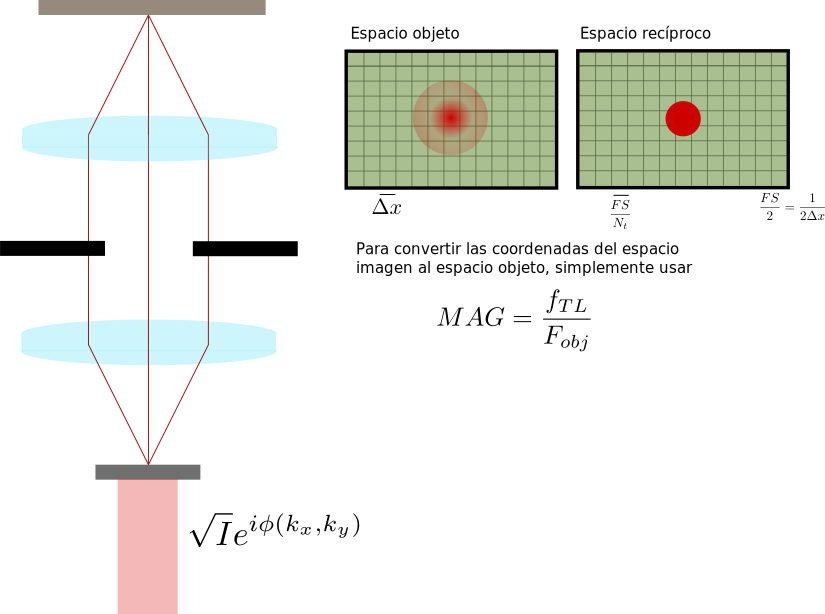

In [26]:
display(SVG('lens_system.svg'))

En el plano transformado, la frecuencia espacial máxima esta relacionada con la resolución por difracción y por el criterio de Rayleigh es $k_{max}=\frac{2\pi}{0.61\lambda}$. De modo que la frecuencia de corte del sistema óptico ideal es $\frac{2\pi}{0.61\lambda}=0.61*k_0$.

NOTA: el primer cero en la función de Airy se encuentra en $x*k_0*NA=1.22\pi$, con lo cual en una pantalla el primer cero estará en $x=0.61*\frac{\lambda}{NA}$.


In [ ]:
wavelength = 450E-9
k0 = 2*np.pi/wavelength
NA = 0.12
cutoff_frequency = k0*NA

Para hacer cálculos en el dominio muestreado, hay que tener en cuenta justamente la discretización del sensor. Los dos parámetros que lo definen (al menos en una primera aproximación) son el tamaño del pixel (ps) y sus dimensiones (numero de pixeles en x y en y, cantidad que en éste párrafo llamaremos np). Para simplificar algunas cosas se puede trabajar con coordenadas en el plano objeto (es decir, considerando la magnificacón del sistema), de esta manera es $ps = \frac{tam_pixel}{M}$. De acuerdo a la teoría del muestreo, la frecuencia máxima corresponderá a $fs=\frac{1}{ps}$, siendo $\delta f = \frac{\fs}{np}$
La frecuencia de muestreo más alta es $\frac{2\pi}{pixel}$, con pasos dados por $\frac{2\pi}{NPX*PS}$ (siendo NPX la cantidad de pixeles en una dada dimensión, para ambos casos es totalemente análogo, debiendose tomar la precaución de usar el PS adecuado si los pixeles no son cuadrados). El radio de la pupila en estas coordenadas vendrá dado por $\frac{NA}{\lambda}$

In [ ]:
# Maximum sampling frequency calculation
magnification = 8
pixel_size = 5.670E-6/magnification
NPX, NPY = [400, 400]
pupil_radius = NA/wavelength
fs = 1/pixel_size
df = fs/NPX
pupil_radius_pixels = pupil_radius/df
fx = np.arange(-fs / 2, fs / 2, step = df)*1E-6 # Spatial frequency, inverse microns
pupil = fpm.generate_pupil(theta=0, phi=0, power=0, image_size=[NPY, NPX],
                       wavelength=wavelength, pixel_size=pixel_size, na=NA)
# Show the pupil
ax = plt.imshow(np.abs(pupil), extent = [fx[0], fx[-1], fx[0], fx[-1]])
plt.grid(False)
cb = plt.colorbar(ax)
cb.set_label('$P \, ( f_x, f_y ) $')
plt.xlabel('$f_x$, $\mu m^{-1}$')
plt.ylabel('$f_y$, $\mu m^{-1}$')
plt.show()


La pupila tiene el efecto pasabajos sobre la imagen. En el siguiente ejemplo se trabaja en coordenadas dadas por el número de onda donde se ilustra dicho efecto.

In [ ]:
from scipy import fftpack, ndimage
## El objeto muestreado
objectIntensity = ndimage.imread('cameraman.tif', flatten=True)     # flatten=True gives a greyscale image
objectAmplitude = np.sqrt(objectIntensity)
objectAmplitudeFT = fftpack.fftshift(fftpack.fft2(objectAmplitude))
m, n = np.shape(objectAmplitude)
kx = np.linspace(-np.pi/pixel_size, np.pi/pixel_size,n)
ky = np.linspace(-np.pi/pixel_size, np.pi/pixel_size, m)
kxm, kym = np.meshgrid(kx, ky, sparse = True)
CTF = (kxm**2+kym**2<cutoff_frequency**2).astype(int)
outputFT = CTF*objectAmplitudeFT
outputAmplitude = fftpack.ifft2(fftpack.ifftshift(outputFT))
outputIntensity = np.abs(outputAmplitude**2)
# plt.imshow(np.log(np.abs(outputFT)), cmap='gray')
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(15,15))
ax[0].imshow(outputIntensity, cmap='gray')
ax[1].imshow(objectIntensity, cmap='gray')
ax[2].imshow(CTF, cmap='gray')
plt.show()

## Onda plana incidente con ángulo variable

Al incidir una onda plana $Ae^{i\phi(kx,ky)}$ sobre una muestra situeda en el foco de una lente (como en la figura de arriba), en el plano focal trasero de la misma de obtiene un campo con una distribución que puede aproximarse como la transformada de fourier de la onda incidente por una función $t(x,y)$ que modela la transmisión de la muestra. 

Ahora bien, en una imagen con un tamaño de pixel dado, la máxima resolución asequible viene dada por $\frac{FS}{2}=\frac{1}{2\Delta x}$, que a si vez corresponde a una cantidad apertura numerica $\frac{1}{2\Delta x r_{pup}}$ veces mayor que la que el sistema físico posee.
Por ejemplo, tomando los valores ya calculados arriba, se tiene que la apertura numérica sintética máxima (correspondiente a una pupila que abarque totalmente el sensor) tendria que ser

In [ ]:
NA_max = NA*1/(2*pixel_size*pupil_radius)
angle_max = np.arcsin(NA_max)*180/np.pi
print('Maxima NA sintetica:\t%.2f' % (NA_max))
print('Maximo angulo zenital correspondiente:\t%.2fº' % (angle_max))

Esto no quiere decir que no se puedan conseguir aperturas sintéticas mayores con la técnica; no es un límite físico insuperable y veremos más adelante como superarlo. El sistema de iluminación se define en el sistema de coordenadas mostrado en la figura. La correcta definición de los ángulos y proyecciones es importante dado que son las que se usarán para generar los corrimientos en la pupila que luego definirán la apertura sintética del sistema.

In [ ]:
display(SVG('angle_definition.svg'))

La onda plana incidente puede reescribirse en función de estos ángulos como 

\begin{equation}
Ae^{\frac{2\pi}{\lambda} \left(\sin\varphi\cos\theta,\,\sin\varphi\sin\theta \right)}.
\end{equation}

Ahora bien, trabajando en frecuencias espaciales hemos visto que el valor máximo muestreable por el sensor está en $\frac{FS}{2}=\frac{1}{2\Delta x}$, lo cual quiere decir que no tiene sentido, para un dado tamaño de pixel, mover a la pupila más allá de $\frac{FS}{2}-r_{pup}=\frac{1}{2\Delta x}-\frac{NA}{\lambda}$

En valores muestrales, esto es

\begin{equation}
\frac{N_{PX}}{2}-\frac{NA \Delta x N_{PX}}{\lambda}
\end{equation}

Usando estas consideraciones se pueden obtener algunas útiles conclusiones:

1) Dado que el módulo de la proyección de f ($f=\frac{k}{2\pi}$) en el plano de fourier viene dado por $\frac{\sin\varphi}{\lambda}$ y la máxima frecuencia muestral es $\frac{1}{2 \Delta x}$. Considerando una pupila pequeña (cuasi puntual) el valor más extremo que puede tomar $\phi$ en esta configuración es $\sin^{-1}\frac{\lambda}{2 \Delta x}$. De acá puede verse que muestrear a más de $\frac{\Delta x}{2}$ no tiene sentido físico (equivale a decir que el límite en la mejora de la resolución viene dado por el límite de difracción).

2) Dado un determinado sensor, el valor extremo de muestreo coincide la proyección de este $\varphi_{max}$

3) Teniendo en cuenta ahora en ancho de la pupila, no tiene sentido correr su centro a una posición más lejana que aquella en la que su borde toca el extremo más lejano del sensor, con lo cual $\varphi_{max}$ es más pequeño que lo mencionado en el punto anterior. De hecho, vale 
\begin{equation}
\varphi_{max}=\sin^{-1}\left( \frac{\lambda}{2 \Delta x}- NA \right)
\end{equation}

4) De manera que las coordenadas del centro de la pupila vendran dadas por

\begin{equation}
(x_c, y_x) + \frac{1}{\lambda} \left(\sin\varphi\cos\theta,\,\sin\varphi\sin\theta \right) \Delta x N_{PX}
\end{equation}



In [ ]:
phi_max = np.arcsin(wavelength/(2*pixel_size)-NA)
phi_max = np.degrees(phi_max)
print('Maximo angulo zenital correspondiente:\t%.2fº' % phi_max)
phi = phi_max
theta = 0
pupil = fpm.generate_pupil(theta=0, phi=phi, power=0, image_size=[NPY, NPX],
                       wavelength=wavelength, pixel_size=pixel_size, na=NA)
# Show the pupil
ax = plt.imshow(np.abs(pupil), extent = [fx[0], fx[-1], fx[0], fx[-1]])
plt.grid(False)
cb = plt.colorbar(ax)
cb.set_label('$P \, ( f_x, f_y ) $')
plt.xlabel('$f_x$, $\mu m^{-1}$')
plt.ylabel('$f_y$, $\mu m^{-1}$')
plt.show()


## El phi máximo no es tan máximo

Arriba hemos calculado el phi máximo para una dada configuración, pero en esta aplicación este límite puede quebrarse dado que independientemente de todas las características del sensor y la iluminación siempre puede tomarse una foto de el objeto bajo un angulo zenital mayor y ésta contendrá información de alta frecuencia de obeto sensado a pesar de que por los medios usuales ésta no pueda medirse. Dado que la frecuencia máxima de muestreo está relacionada con el tamaño del píxel, esta información fuera del dominio de muestreo puede considerarse como una relación proporcional (y "virtual") del tamaño del pixel.

Por un lado está la información del objeto "por fuera" de la apertura numérica del sistema óptico sobre la que hemos tratado hasta recién. Por otro está la información que supera la máxima frecuencia espacial admisible por el sensor. 

Si simplemente cambio el tamaño de pixel, el efecto neto es que la pupila se achica sobre el mismo área. Para que la pupila conserve su tamaño (y por lo tanto el objeto filtrado posea la misma información espectral que el original), también hay que cambiar proporcionalmente la cantidad de los pixels (es decir, el tamaño total del sensor debe permanecer invariante). Un ejemplo de esto se muestra en la siguiente simulación de muestreo.


In [ ]:
from scipy import fftpack, ndimage
## El objeto muestreado
pixel_size_scale = 5E-8
f0 = 1/wavelength
objectIntensity = ndimage.imread('Image_4a_mag.png', flatten=True)     # flatten=True gives a greyscale image
def sample(objectIntensity, pixel_size, k0, resize_factor):
    pixel_size = pixel_size/resize_factor
    objectIntensity = ndimage.zoom(objectIntensity, resize_factor, order=0)
    objectAmplitude = np.sqrt(objectIntensity)
    objectAmplitudeFT = fftpack.fftshift(fftpack.fft2(objectAmplitude))
    m, n = np.shape(objectAmplitude)
    fx = np.linspace(-1/(pixel_size*2), 1/(pixel_size*2),n)
    fy = np.linspace(-1/(pixel_size*2), 1/(pixel_size*2), m)
    fxm, fym = np.meshgrid(fx, fy, sparse = True)
    CTF = (fxm**2+fym**2<f0**2).astype(int)
    outputFT = CTF*objectAmplitudeFT
    outputAmplitude = fftpack.ifft2(fftpack.ifftshift(outputFT))
    outputIntensity = np.abs(outputAmplitude**2)
    return outputIntensity, CTF

out1, pupil1 = sample(objectIntensity, pixel_size_scale, k0, .5)
out2, pupil2 = sample(objectIntensity, pixel_size_scale, k0, 2)
# plt.imshow(np.log(np.abs(outputFT)), cmap='gray')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(15,12))
ax1.imshow(out1, cmap='gray')
ax2.imshow(pupil1, cmap='gray')
ax3.imshow(out2, cmap='gray')
ax4.imshow(pupil2, cmap='gray')
plt.show()

En ambos casos se escaló de la misma manera el tamaño del pixel y la cantidad de pixeles en la imagen, siendo en el primer caso el factor de escala 0.5 y en el segundo de 2. Dado que el tamaño de la pupila es $\frac{NA}{\lambda}*\frac{1}{NPX*PS}$ la relación entre el tamaño de la pupila y el tamaño de la imagen sigue el mismo factor de escala. Hay que recordar que la transformada de una imagen ampliada se comprime con el mismo factor de escala, por lo cual la información espectral dentro de ambas áreas es la misma pero hay más lugar para mover la pupila. 

De hecho, para ambos casos vale:

In [ ]:
phi_max1 = np.arcsin(wavelength/(2*pixel_size/0.5)-NA)
phi_max2 = np.arcsin(wavelength/(2*pixel_size/2.)-NA)
print("NPX de la imagen de arriba %i. Angulo zenital máximo: %.1fº" % (np.shape(out1)[0], np.degrees(phi_max1) ))
print("NPX de la imagen de abajo %i. Angulo zenital máximo: %.1fº" % (np.shape(out2)[0], np.degrees(phi_max2) ))

Se puede calcular el tamaño del pixel para un dado ángulo máximo según:
\begin{equation}
PS = \frac{\lambda}{2 \left( \sin\varphi_{max}  +NA \right)}
\end{equation}

In [ ]:
def pixel_size_required(phi_max, wavelength, NA):
    phi_max_rad = np.radians(phi_max)
    return wavelength/(np.sin(phi_max_rad)+NA)/2
NA = 0.12
wavelength = 450E-9
phi_max = 30
print("Tamaño de pixel requerido: %.2f nm" % (1E9*pixel_size_required(phi_max, wavelength, NA)))

## Simulación realista de una adquisición

Para la simulación realista con los parámetros físicos reales del sistema hay que tener una imagen con información de fase. La información de módulo y fase de la muestra vienen dados básicamente por la absorción, la profundidad y el índice de refracción en cada punto muestreado.

In [ ]:
image_size = [500, 500]
nx, ny = image_size
xc, yc = fpm.image_center(image_size)
xsp, ysp = [xc, yc]
rad = 70
coords = np.array([xc, yc])
pup_matrix = np.zeros(image_size, dtype=np.uint8)
xx, yy = np.meshgrid(range(ny), range(nx))
c = (xx-xsp)**2+(yy-ysp)**2
image_gray = c
# image_gray = [c < rad**2][0]
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 5))
ax1.imshow(image_gray)
plt.plot()

In [8]:
%load_ext autoreload
import matplotlib
matplotlib.use('Qt4Agg')
matplotlib.interactive(True)
# %matplotlib inline
import mayavi.mlab as mlab
import matplotlib.pyplot as plt

def generate_model(nx, ny):
    """Test surf on regularly spaced co-ordinates like MayaVi."""
    xx, yy = np.mgrid[-1.:1:nx*1j, -1.:1:ny*1j]
    
    def sample_height(xx, yy, cx, cy, rad):
        sample_height = .1*np.exp(-(2*(xx-cx)**2 + (yy-cy)**2)/rad**2)/(rad**2)-.2
        sample_height[sample_height < 0] = 0
#         sample_height[sample_height > 0] += .1
        return sample_height
    
    def refraction_index(xx, yy):
        refraction_index = .5*np.ones_like((xx))
        return refraction_index
    
    def absorption(xx, yy):
        sample_absorption = 1.5*np.zeros_like((xx))
        return sample_absorption
    
    sample_height = sample_height(xx, yy, 0, 0, .55)
    sample_refind = refraction_index(xx, yy)
    sample_abs = absorption(xx, yy)
#     h += height(xx, yy, .1, .2, .5) 
    return xx, yy, sample_height, sample_refind, sample_abs

def mayavi_plot_sample():
    xx, yy, height, refind, absorption = generate_model(500, 500)
    print(refind)
    s = mlab.surf(xx, yy, height)
    return s
    
mayavi_plot_sample()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 ..., 
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
 [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]]


In [23]:
xx, yy = np.mgrid[-1.:1:10*1j, -1.:1:10*1j]


[(-1.0,
  -0.77777777777777779,
  -0.55555555555555558,
  -0.33333333333333337,
  -0.11111111111111116,
  0.11111111111111116,
  0.33333333333333326,
  0.55555555555555536,
  0.77777777777777768,
  1.0),
 (-1.0,
  -0.77777777777777779,
  -0.55555555555555558,
  -0.33333333333333337,
  -0.11111111111111116,
  0.11111111111111116,
  0.33333333333333326,
  0.55555555555555536,
  0.77777777777777768,
  1.0),
 (-1.0,
  -0.77777777777777779,
  -0.55555555555555558,
  -0.33333333333333337,
  -0.11111111111111116,
  0.11111111111111116,
  0.33333333333333326,
  0.55555555555555536,
  0.77777777777777768,
  1.0),
 (-1.0,
  -0.77777777777777779,
  -0.55555555555555558,
  -0.33333333333333337,
  -0.11111111111111116,
  0.11111111111111116,
  0.33333333333333326,
  0.55555555555555536,
  0.77777777777777768,
  1.0),
 (-1.0,
  -0.77777777777777779,
  -0.55555555555555558,
  -0.33333333333333337,
  -0.11111111111111116,
  0.11111111111111116,
  0.33333333333333326,
  0.55555555555555536,
  0.7777777

## Bibliografía

http://kmdouglass.github.io/posts/simple-pupil-function-calculations.html